In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

In [2]:
Crema="/kaggle/input/speech-emotion-recognition-en/Crema"
ravdess="/kaggle/input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"

In [3]:
crema_directory_list = os.listdir(Crema)
ravdess_directory_list = os.listdir(ravdess)


In [4]:
ravdess_directory_list = os.listdir(ravdess)


In [5]:
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema+ "/" + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
1,happy,/kaggle/input/speech-emotion-recognition-en/Cr...
2,happy,/kaggle/input/speech-emotion-recognition-en/Cr...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...
4,disgust,/kaggle/input/speech-emotion-recognition-en/Cr...


In [6]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess +'/'+ i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + '/' + i + '/' + f)

In [7]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
ravdess_df.head()

/tmp/ipykernel_34/2600091737.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',


,Emotions,Path
0,surprise,/kaggle/input/speech-emotion-recognition-en/Ra...
1,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...
2,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
4,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...


In [8]:
data_path = pd.concat([ravdess_df, Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/speech-emotion-recognition-en/Ra...
1,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...
2,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
3,disgust,/kaggle/input/speech-emotion-recognition-en/Ra...
4,neutral,/kaggle/input/speech-emotion-recognition-en/Ra...


<Axes: xlabel='Emotions'>

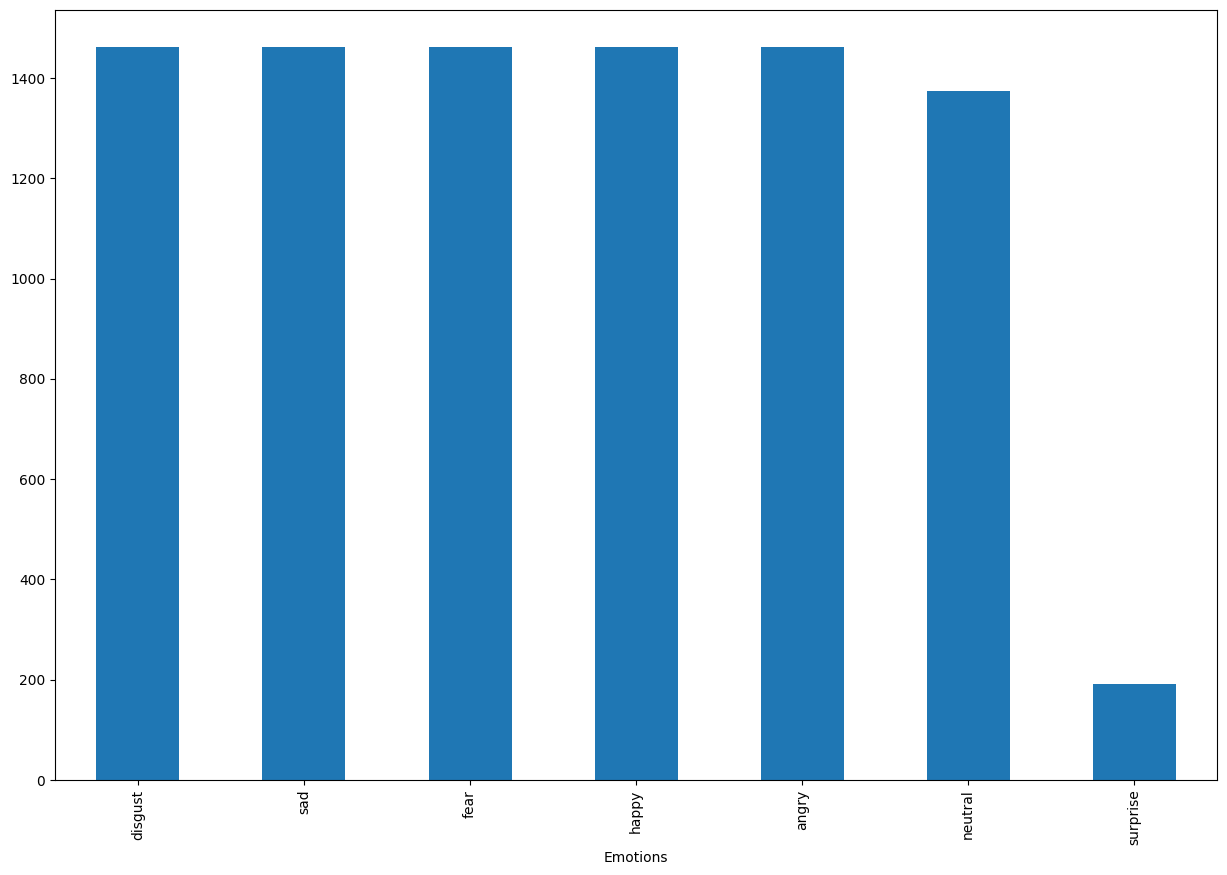

In [11]:
plt.figure(figsize=(15,10))
data_path.Emotions.value_counts().plot(kind='bar')

In [12]:
data_path.shape

(8882, 2)

In [13]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate,n_steps= pitch_factor)

In [14]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=5.2, offset=0.9):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    # Extract features for noised audio
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))

    # Extract features for pitched audio
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))
    
    return audio

In [15]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%1000==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start) 

2it [00:10,  4.39s/it]

0 audio has been processed


1001it [03:45,  4.68it/s]

1000 audio has been processed


2001it [06:36,  8.60it/s]

2000 audio has been processed


3002it [09:06,  7.10it/s]

3000 audio has been processed


4002it [11:38,  7.07it/s]

4000 audio has been processed


5002it [14:10,  7.13it/s]

5000 audio has been processed


6001it [16:42,  5.77it/s]

6000 audio has been processed


7002it [19:16,  7.15it/s]

7000 audio has been processed


8001it [21:48,  7.08it/s]

8000 audio has been processed


8882it [24:02,  6.16it/s]

Done
Time:  1442.019165986


In [16]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,4149,4150,4151,4152,4153,4154,4155,4156,4157,Emotions
0,0.157715,0.247559,0.378418,0.344727,0.354980,0.358398,0.328125,0.359375,0.306641,0.235352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,surprise
1,0.238770,0.375977,0.499512,0.500977,0.511719,0.476074,0.457520,0.431641,0.338867,0.264648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,surprise
2,0.130859,0.174805,0.276855,0.305176,0.355957,0.411621,0.402832,0.354004,0.278320,0.189941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,surprise
3,0.063965,0.231445,0.359375,0.483887,0.527832,0.451172,0.415039,0.328613,0.254883,0.213867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral
4,0.244629,0.372559,0.490234,0.497559,0.484375,0.448730,0.422852,0.334473,0.257812,0.215820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral


In [17]:
Emotions.tail()

,0,1,2,3,4,5,6,7,8,9,...,4149,4150,4151,4152,4153,4154,4155,4156,4157,Emotions
26641,0.022949,0.029785,0.036621,0.034180,0.032715,0.036133,0.039062,0.039551,0.036621,0.032715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
26642,0.018555,0.026367,0.032715,0.028320,0.028320,0.028320,0.031250,0.032227,0.034180,0.031250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
26643,0.019531,0.029297,0.038574,0.041992,0.052246,0.062012,0.067871,0.060059,0.049805,0.042969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
26644,0.082520,0.125488,0.168945,0.177734,0.206543,0.215820,0.204590,0.166504,0.125000,0.101562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad
26645,0.018555,0.026855,0.036621,0.032715,0.030762,0.037598,0.041016,0.044434,0.045898,0.043945,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sad


In [18]:
Emotions=Emotions.fillna(0)
Emotions.shape

(26646, 4159)

In [19]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [20]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=100,test_size=0.3, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((18652, 4158), (18652, 7), (7994, 4158), (7994, 7))

In [22]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((18652, 4158, 1), (18652, 7), (7994, 4158, 1), (7994, 7))

In [23]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, BatchNormalization, Dropout, Flatten, Dense 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

2024-05-10 04:28:44.153445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 04:28:44.153550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 04:28:44.294156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, BatchNormalization, Dropout, Input

model = Sequential()
model.add(Input(shape=(4158,1)))  # Add input layer

model.add(Conv1D(512, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))  # Add dropout layer after the third max pooling layer

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))  # Add dropout layer after the fourth max pooling layer

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4154, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4154, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2077, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2077, 256)      │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2077, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1039, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1039, 256)      │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1039, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 520, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 520, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 520, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 520, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 260, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 260, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    17,039,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,004,103 (68.68 MB)

 Trainable params: 18,000,775 (68.67 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [25]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=128)

Epoch 1/50


I0000 00:00:1715315365.953136     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715315365.975826     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.3392 - loss: 1.9046

W0000 00:00:1715315427.393084     143 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.3395 - loss: 1.9028

W0000 00:00:1715315428.827114     142 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 474ms/step - accuracy: 0.3397 - loss: 1.9009 - val_accuracy: 0.2148 - val_loss: 3.9578
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.4188 - loss: 1.4581 - val_accuracy: 0.2948 - val_loss: 1.9109
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.4653 - loss: 1.3603 - val_accuracy: 0.3481 - val_loss: 1.6514
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.4953 - loss: 1.2857 - val_accuracy: 0.3974 - val_loss: 1.5344
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.5245 - loss: 1.2124 - val_accuracy: 0.4051 - val_loss: 1.5842
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.5486 - loss: 1.1588 - val_accuracy: 0.4722 - val_loss: 1.4039
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.5820 - loss: 1.0751 - val_accuracy: 0.4636 - val_loss: 1.4015
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.6200 - loss: 0.9851 - val

250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8506 - loss: 0.6034
Accuracy of our model on test data :  84.7760796546936 %


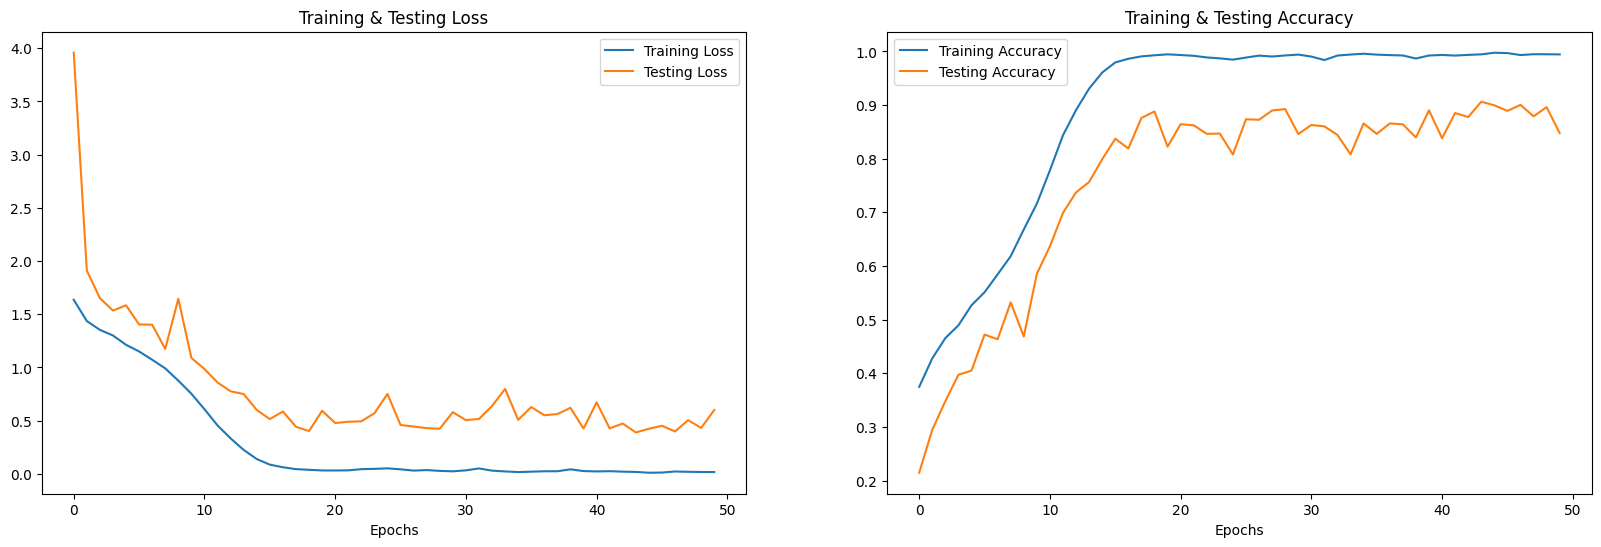

In [26]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [27]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,disgust,disgust
2,angry,angry
3,fear,fear
4,disgust,disgust
...,...,...
7989,fear,sad
7990,sad,sad
7991,disgust,disgust
7992,neutral,neutral


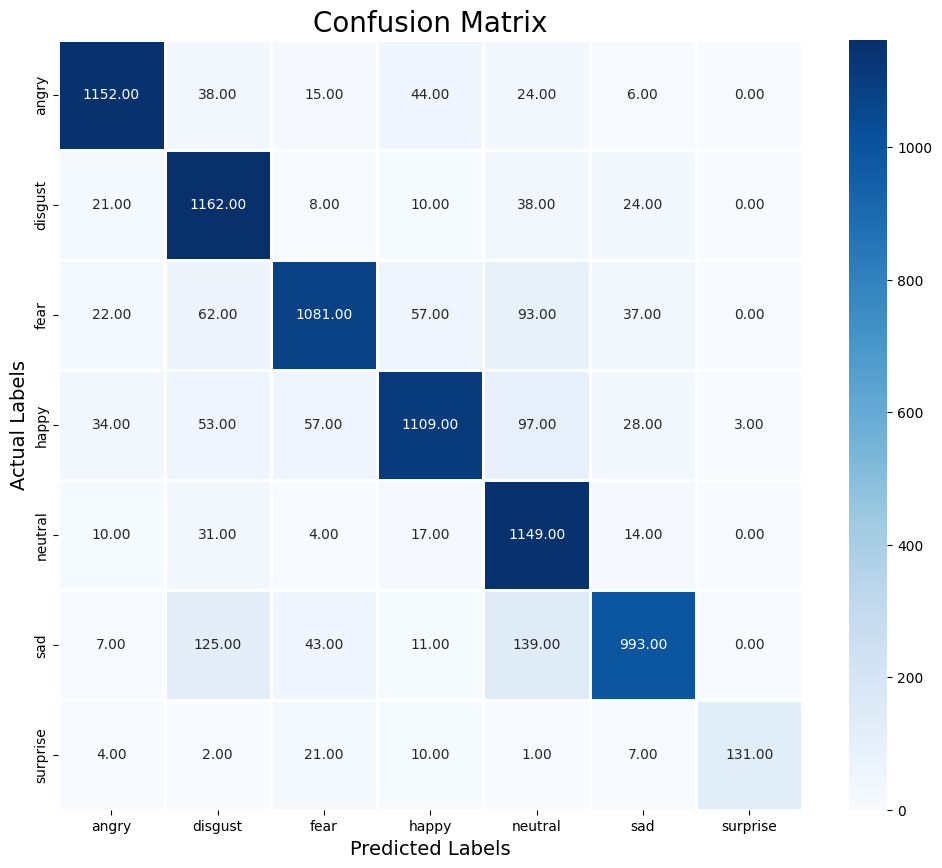

              precision    recall  f1-score   support

       angry       0.92      0.90      0.91      1279
     disgust       0.79      0.92      0.85      1263
        fear       0.88      0.80      0.84      1352
       happy       0.88      0.80      0.84      1381
     neutral       0.75      0.94      0.83      1225
         sad       0.90      0.75      0.82      1318
    surprise       0.98      0.74      0.85       176

    accuracy                           0.85      7994
   macro avg       0.87      0.84      0.85      7994
weighted avg       0.86      0.85      0.85      7994



In [28]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# **Saving Model**

In [30]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("DCA_SER.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("DCA_SER.weights.h5")
print("Saved model to disk")

Saved model to disk


# **Importing Model** 

In [31]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/DCA_SER.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/DCA_SER.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8506 - loss: 0.6034
compile_metrics: 84.78%


# **taking input from user**


In [39]:
trail_path = '/kaggle/input/trail/pyaudio recordings'
trail_list= os.listdir('/kaggle/input/trail/pyaudio recordings')
file_path_trail = []
for i in trail_list:
    user = os.listdir( trail_path +'/'+ i)
    for f in user:
        file_path_trail.append(trail_path + '/' + i + '/' + f)
        

In [40]:
# dataframe for emotion of files
predictions = pd.DataFrame(file_path_trail, columns=['Path'])

predictions.head(17)

,Path
0,/kaggle/input/trail/pyaudio recordings/mannu/W...
1,/kaggle/input/trail/pyaudio recordings/mannu/m...
2,/kaggle/input/trail/pyaudio recordings/mannu/W...
3,/kaggle/input/trail/pyaudio recordings/mannu/W...
4,/kaggle/input/trail/pyaudio recordings/mannu/W...
5,/kaggle/input/trail/pyaudio recordings/mannu/W...
6,/kaggle/input/trail/pyaudio recordings/mannu/W...
7,/kaggle/input/trail/pyaudio recordings/mannu/W...
8,/kaggle/input/trail/pyaudio recordings/chinto/...
9,/kaggle/input/trail/pyaudio recordings/chinto/...


In [41]:
def feat_pred(path,duration=4.38, offset=0.9):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    return audio

In [42]:
# def feat_pred1(path,duration=4.38, offset=0.9):
#     data,sr=librosa.load(path,duration=duration,offset=offset)
#     aud=extract_features(data)
#     audio=np.array(aud)
#     return audio

In [43]:
x_predictions1 = []
for path in predictions.Path:
    feat = feat_pred(path)
    x_predictions1.append(feat)

In [44]:
prde = pd.DataFrame(x_predictions1)
prde.head()

,0,1,2,3,4,5,6,7,8,9,...,4148,4149,4150,4151,4152,4153,4154,4155,4156,4157
0,0.019043,0.028809,0.043457,0.054688,0.071289,0.085938,0.097656,0.098633,0.089844,0.079590,...,-14.481586,-27.615406,5.980101,-1.308239,-9.597458,-9.301247,-9.706366,-2.913579,5.029386,-3.715084
1,0.035156,0.050293,0.060059,0.049805,0.036133,0.024414,0.021484,0.017090,0.018555,0.022461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.024902,0.035645,0.050781,0.061035,0.073242,0.090332,0.094727,0.095215,0.099609,0.096191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.011719,0.021973,0.033691,0.039551,0.044922,0.040039,0.036133,0.033203,0.031738,0.037109,...,-4.182697,-5.473789,-2.307386,1.661730,1.038964,2.120046,2.803904,-4.979331,-0.500268,-1.562366
4,0.026367,0.046875,0.070312,0.081055,0.098145,0.102539,0.097168,0.091309,0.071777,0.061035,...,-12.271216,-7.085598,8.551682,2.860916,-8.503815,-6.268877,1.934580,0.265324,-3.199594,0.279729


In [45]:
new_data = np.zeros((prde.shape[0], x_train.shape[1]))
new_data[:, :prde.shape[1]] = prde
prde1 = pd.DataFrame(new_data)
prde1 = prde1.fillna(0)
prde1.head()

,0,1,2,3,4,5,6,7,8,9,...,4148,4149,4150,4151,4152,4153,4154,4155,4156,4157
0,0.019043,0.028809,0.043457,0.054688,0.071289,0.085938,0.097656,0.098633,0.089844,0.079590,...,-14.481586,-27.615406,5.980101,-1.308239,-9.597458,-9.301247,-9.706366,-2.913579,5.029386,-3.715084
1,0.035156,0.050293,0.060059,0.049805,0.036133,0.024414,0.021484,0.017090,0.018555,0.022461,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.024902,0.035645,0.050781,0.061035,0.073242,0.090332,0.094727,0.095215,0.099609,0.096191,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.011719,0.021973,0.033691,0.039551,0.044922,0.040039,0.036133,0.033203,0.031738,0.037109,...,-4.182697,-5.473789,-2.307386,1.661730,1.038964,2.120046,2.803904,-4.979331,-0.500268,-1.562366
4,0.026367,0.046875,0.070312,0.081055,0.098145,0.102539,0.097168,0.091309,0.071777,0.061035,...,-12.271216,-7.085598,8.551682,2.860916,-8.503815,-6.268877,1.934580,0.265324,-3.199594,0.279729


In [46]:
prde1 = np.expand_dims(prde1, axis=2)
prde1.shape

(17, 4158, 1)

In [47]:
prds = history.model.predict(prde1)
y_prds = encoder.inverse_transform(prds)
y_prds

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([['angry'],
       ['angry'],
       ['disgust'],
       ['angry'],
       ['disgust'],
       ['sad'],
       ['fear'],
       ['disgust'],
       ['disgust'],
       ['disgust'],
       ['sad'],
       ['disgust'],
       ['disgust'],
       ['neutral'],
       ['disgust'],
       ['disgust'],
       ['fear']], dtype=object)